In [1]:
import sys
sys.path
sys.path.append('../service/')

print(sys.executable)

In [2]:
# standart libs
import random
import copy

# 3rd party libs
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import gempy as gp
from gempy.utils import section_utils

# local
import functions as fun

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Init the geo_model

In [3]:
# instantiate the geo_model
geo_model = gp.create_model("BaseModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[5, 5, 5]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


### Series

In [4]:
# set some series
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[2] = { 'order_series': 2, 'name': 'Fault_Series', 'isfault': True }
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

In [5]:
# old series
geo_model.add_series(series_list=['S1', 'S2', 'S3'])

,order_series,BottomRelation,isActive
Default series,1,Erosion,False
S1,2,Erosion,NaN
S2,3,Erosion,NaN
S3,4,Erosion,NaN


In [6]:
fun.update_series(geo_model, series_df)
geo_model.series.df

Fault colors changed. If you do not like this behavior, set change_color to False.
HOTFIX in update_series()


,order_series,BottomRelation,isActive
Fault_Series,1,Fault,False
Basement,2,Erosion,False
Strat_Series,3,Erosion,False


### Surfaces

In [7]:
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'Sandstone', 'serie': 'Strat_Series', 'order_surface': 0 }
surfaces_df.loc[1] = { 'name': 'Silt', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df.loc[2] = { 'name': 'Shale', 'serie': 'Strat_Series', 'order_surface': 2 }

In [8]:
geo_model.add_surfaces(['Fake1', 'Fake2'])

,surface,series,order_surfaces,isActive,color,id
0,Fake1,Strat_Series,1,nan,#015482,1
1,Fake2,Strat_Series,2,nan,#9f0052,2


In [9]:
fun.update_surfaces(geo_model, surfaces_df)
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,color,vertices,edges,sfai,id
0,Sandstone,Strat_Series,1,False,False,NaN,#015482,NaN,NaN,NaN,1
1,Silt,Strat_Series,2,False,False,NaN,#9f0052,NaN,NaN,NaN,2
2,Shale,Strat_Series,3,True,False,NaN,#ffbe00,NaN,NaN,NaN,3


### Input

In [10]:
geo_model_extent = [0,2000,0,2000,0,2000]
section = {
    'p1': [0, 1000],
    'p2': [2000, 1000],
    'resolution': [200, 200]
}

series_df = pd.read_csv('./data/simple_fault_model_series.csv')
surfaces_df = pd.read_csv('./data/simple_fault_model_surfaces.csv')

surface_points_input_data = pd.read_csv('./data/simple_fault_model_points.csv')
orientaions_input_data = pd.read_csv('./data/simple_fault_model_orientations.csv')

# Format geological_input_data
surface_points_original_df = surface_points_input_data[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df['param1'] = 10

# Orientaions
orientations_original_df = orientaions_input_data[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

In [11]:
fun.set_congiguration(geo_model, geo_model_extent, section)
fun.update_series(geo_model, series_df)
fun.update_surfaces(geo_model, surfaces_df)
geo_model.set_surface_points(surface_points_original_df, update_surfaces=False)
geo_model.set_orientations(orientations_original_df, update_surfaces=False)
geo_model.update_to_interpolator()

Active grids: ['regular']
Active grids: ['regular' 'sections']
Fault colors changed. If you do not like this behavior, set change_color to False.
HOTFIX in update_series()


True

In [12]:
fun.check_setup_single_realization(geo_model)

Run realizations setup checks until stable workflow.


In [17]:
solution = gp.compute_model(model=geo_model, sort_surfaces=True)
solution = gp.compute_model(model=geo_model, sort_surfaces=True)
# solution = gp.compute_model(model=geo_model, sort_surfaces=True)

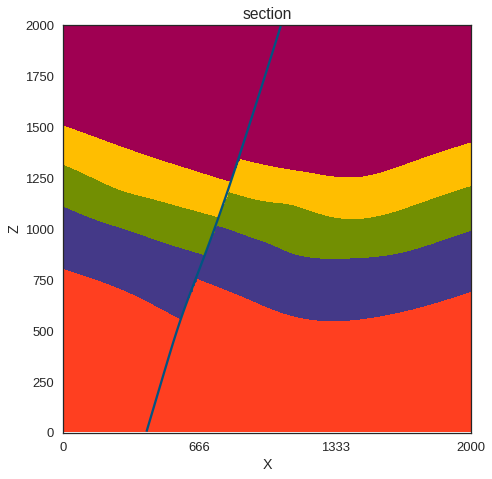

In [18]:
polygondict, cdict, extent = gp.utils.section_utils.get_polygon_dictionary(
    geo_model=geo_model,
    section_name="section"
)

In [15]:
# Constants
n_realizations = 10

# Run realizations
list_section_data = fun.run_realizations(
    geo_model=geo_model,
    n_realizations=n_realizations,
    surface_points_original_df=surface_points_original_df,
    orientations_original_df=orientations_original_df,
    section=section
)

# Process output
section_data_stack, lithology_ids = fun.process_list_section_data(
    list_section_data=list_section_data)

# Count occurrences
count_array = fun.count_lithology_occurrences_over_realizations(
        section_data_stack=section_data_stack,
        lithology_ids=lithology_ids,
        section=section
)

# Calculate entrop
entropy_map = fun.calculate_information_entropy(
    count_array=count_array, n_realizations=n_realizations)

Realization: 0
Realization: 1
Realization: 2
Realization: 3
Realization: 4
Realization: 5
Realization: 6
Realization: 7
Realization: 8
Realization: 9


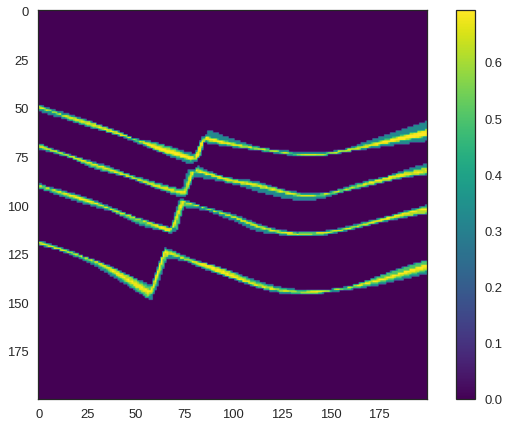

In [16]:
plt.imshow(entropy_map[:,::-1].T, cmap='viridis')
plt.colorbar()
plt.show()